# Multi-Auditor Drift Comparison

In [1]:
import os
import re
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('.')
sys.path.append('..')

In [2]:
plt.style.use('./arena.mplstyle')

# Color palette for PC lines
PC_COLORS = [
    '#4a6fa5',  # muted blue
    '#c4a5a5',  # dusty rose
    '#7d9a78',  # sage green
    '#6b7b8c',  # slate
    '#b8977e',  # clay
    '#1a1a1a',  # charcoal
]

In [15]:
def mean_auto_activations(acts_input_dir, regex_pattern, layer, min_samples=10):
    """Extract (turns, hidden) slice for each file matching the regex pattern.
    
    Returns mean activations and the cutoff turn (first turn with < min_samples).
    """
    slices = []
    max_turns = 0
    H = None

    for file in os.listdir(acts_input_dir):
        if re.match(regex_pattern, file):
            A = torch.load(f"{acts_input_dir}/{file}", weights_only=False, map_location="cpu")['activations']
            T, _, H_cur = A.shape

            T_eff = T - (T % 2)     # drop last turn if odd (user ended conversation)
            if T_eff == 0:
                continue   

            max_turns = max(max_turns, T_eff)

            sl = A[:T_eff, layer, :]  # (T_eff, H_cur)
            slices.append(sl)

            if H is None:
                H = H_cur
            else:
                assert H == H_cur

    if len(slices) == 0:
        raise ValueError("No usable activations after dropping odd last turns.")

    # pad slices with shorter turns with NaN to (N, max_turns, H)
    N = len(slices)
    padded = torch.full((N, max_turns, H), float('nan'))
    for i, sl in enumerate(slices):
        T_eff = sl.shape[0]
        padded[i, :T_eff, :] = sl

    # Count non-NaN samples per turn (check first hidden dim element)
    sample_counts = (~torch.isnan(padded[:, :, 0])).sum(dim=0)  # (max_turns,)

    # Find first turn with < min_samples
    below_threshold = sample_counts < min_samples
    if below_threshold.any():
        cutoff_turn = below_threshold.nonzero()[0].item()
    else:
        cutoff_turn = max_turns

    print(f"{regex_pattern}: {N} samples, cutoff at turn {cutoff_turn}/{max_turns}")

    # Compute mean (full, truncation applied later)
    mean_acts = torch.nanmean(padded[:, :cutoff_turn, :], dim=0)
    return mean_acts, cutoff_turn

In [21]:
# === CONFIGURE TARGET MODEL HERE ===
target_model = "llama-3.3-70b"  # Options: "llama-3.3-70b", "qwen-3-32b", "gemma-2-27b"

# Model-specific layer mapping (middle layer for each model)
MODEL_LAYERS = {
    "llama-3.3-70b": 40,   # 80 layers total
    "qwen-3-32b": 32,      # 64 layers total
    "gemma-2-27b": 22,     # 46 layers total
}

auditor_models = ["gpt-5", "kimi-k2", "sonnet-4.5"]
auditor_display = {"gpt-5": "GPT-5", "kimi-k2": "Kimi K2", "sonnet-4.5": "Sonnet 4.5"}
layer = MODEL_LAYERS[target_model]

domains = ["coding", "writing", "philosophy", "therapy"]
domain_display = {
    "coding": "Coding",
    "writing": "Writing",
    "philosophy": "Philosophy",
    "therapy": "Therapy",
}
domain_order = ["coding", "philosophy", "writing", "therapy"]

In [ ]:
# Load contrast vector
contrast_vector = torch.load(f"/workspace/{target_model}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
contrast_vector = F.normalize(contrast_vector, dim=0) * -1  # normalize and flip sign

# Compute projections for each auditor and domain
auditor_domain_projs = {}
for auditor in auditor_models:
    acts_dir = f"/workspace/{target_model}/dynamics/{auditor}/default/activations"
    
    # First pass: load all domains and get cutoffs
    domain_data = {}
    cutoffs = []
    for domain in domains:
        cache_path = f"{acts_dir}/{domain}_mean.pt"
        
        if os.path.exists(cache_path):
            cached = torch.load(cache_path, weights_only=False)
            # Handle old cache format (just tensor) vs new format (dict)
            if isinstance(cached, dict):
                mean_acts, cutoff = cached['mean_acts'], cached['cutoff']
            else:
                # Old format - recompute to get cutoff
                os.remove(cache_path)
                mean_acts, cutoff = mean_auto_activations(acts_dir, r'^' + domain, layer)
                torch.save({'mean_acts': mean_acts, 'cutoff': cutoff}, cache_path)
                print(f"Upgraded cache: {cache_path}")
            print(f"Loaded cached: {auditor}/{domain} (cutoff={cutoff})")
        else:
            mean_acts, cutoff = mean_auto_activations(acts_dir, r'^' + domain, layer)
            torch.save({'mean_acts': mean_acts, 'cutoff': cutoff}, cache_path)
            print(f"Saved cache: {cache_path}")
        
        domain_data[domain] = mean_acts
        cutoffs.append(cutoff)
    
    # Use minimum cutoff across all domains for this auditor
    min_cutoff = min(cutoffs)
    print(f"  {auditor}: using min cutoff {min_cutoff} (from {cutoffs})")
    
    # Second pass: project with consistent truncation
    auditor_domain_projs[auditor] = {}
    for domain in domains:
        mean_acts = domain_data[domain][:min_cutoff]  # truncate to min
        assistant_acts = mean_acts[1::2]  # odd indices = assistant turns
        proj = assistant_acts.float().numpy() @ contrast_vector.float().numpy()
        auditor_domain_projs[auditor][domain] = proj

print("\nProjections computed for all auditors and domains")

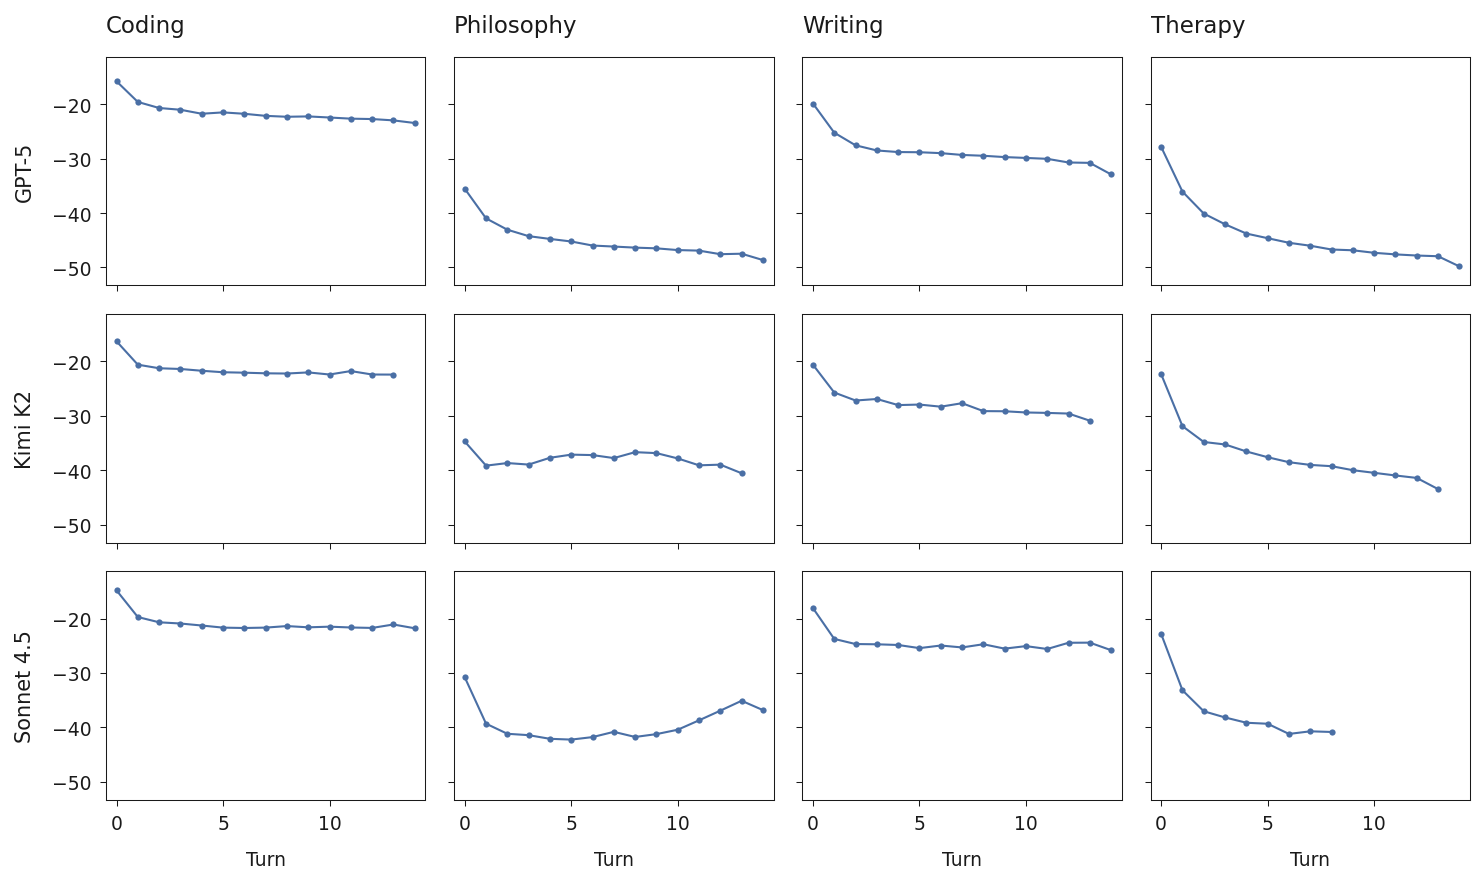

In [ ]:
# Plot grid: rows = auditors, columns = domains
n_auditors = len(auditor_models)
fig, axes = plt.subplots(n_auditors, 4, figsize=(10, 2 * n_auditors), sharex=True, sharey=True)

# Handle single auditor case (axes won't be 2D)
if n_auditors == 1:
    axes = axes.reshape(1, -1)

# Compute global y-range across all auditors and domains
all_y = np.concatenate([
    auditor_domain_projs[auditor][domain]
    for auditor in auditor_models
    for domain in domain_order
])
y_min, y_max = np.nanmin(all_y), np.nanmax(all_y)
y_pad = (y_max - y_min) * 0.1
y_range = (y_min - y_pad, y_max + y_pad)

# Compute global x-range
max_turns = max(
    len(auditor_domain_projs[auditor][domain])
    for auditor in auditor_models
    for domain in domain_order
)

for row_idx, auditor in enumerate(auditor_models):
    for col_idx, domain in enumerate(domain_order):
        ax = axes[row_idx, col_idx]
        proj = auditor_domain_projs[auditor][domain]
        turn_indices = np.arange(len(proj))
        
        ax.plot(turn_indices, proj,
                color=PC_COLORS[0],
                marker='o',
                markersize=3,
                linewidth=1)
        
        ax.set_ylim(y_range)
        ax.set_xlim(-0.5, max_turns - 0.5)
        
        # Ensure box around subplot (all spines visible)
        for spine in ax.spines.values():
            spine.set_visible(True)
        
        # Column titles (domain names) on top row
        if row_idx == 0:
            ax.set_title(domain_display.get(domain, domain.capitalize()), fontsize=11)
        
        # Row labels (auditor names) on left column
        if col_idx == 0:
            ax.set_ylabel(auditor_display.get(auditor, auditor), fontsize=10)
        
        # X-axis label on bottom row
        if row_idx == n_auditors - 1:
            ax.set_xlabel('Turn', fontsize=9)

plt.tight_layout()
plt.show()

# Role PCA Projection (PC1)

In [22]:
# Load role PCA results
role_results = torch.load(f"/workspace/{target_model}/roles_240/pca/layer{layer}_mean_pos23.pt", weights_only=False)

# Compute PC1 projections for each auditor and domain
auditor_domain_pc1_projs = {}
for auditor in auditor_models:
    acts_dir = f"/workspace/{target_model}/dynamics/{auditor}/default/activations"
    
    # Load cached mean activations
    domain_data = {}
    cutoffs = []
    for domain in domains:
        cache_path = f"{acts_dir}/{domain}_mean.pt"
        cached = torch.load(cache_path, weights_only=False)
        mean_acts, cutoff = cached['mean_acts'], cached['cutoff']
        domain_data[domain] = mean_acts
        cutoffs.append(cutoff)
    
    # Use minimum cutoff across all domains
    min_cutoff = min(cutoffs)
    
    # Project onto PC1 using scaler and PCA
    auditor_domain_pc1_projs[auditor] = {}
    for domain in domains:
        mean_acts = domain_data[domain][:min_cutoff]
        assistant_acts = mean_acts[1::2]  # odd indices = assistant turns
        
        # Scale and project
        scaled_acts = role_results['scaler'].transform(assistant_acts.float().numpy())
        projected_acts = role_results['pca'].transform(scaled_acts)
        pc1_proj = projected_acts[:, 0]  # Extract PC1
        
        auditor_domain_pc1_projs[auditor][domain] = pc1_proj

print("PC1 projections computed for all auditors and domains")

/tmp/ipykernel_3277285/4038247936.py:15: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  mean_acts, cutoff = cached['mean_acts'], cached['cutoff']


IndexError: too many indices for tensor of dimension 2

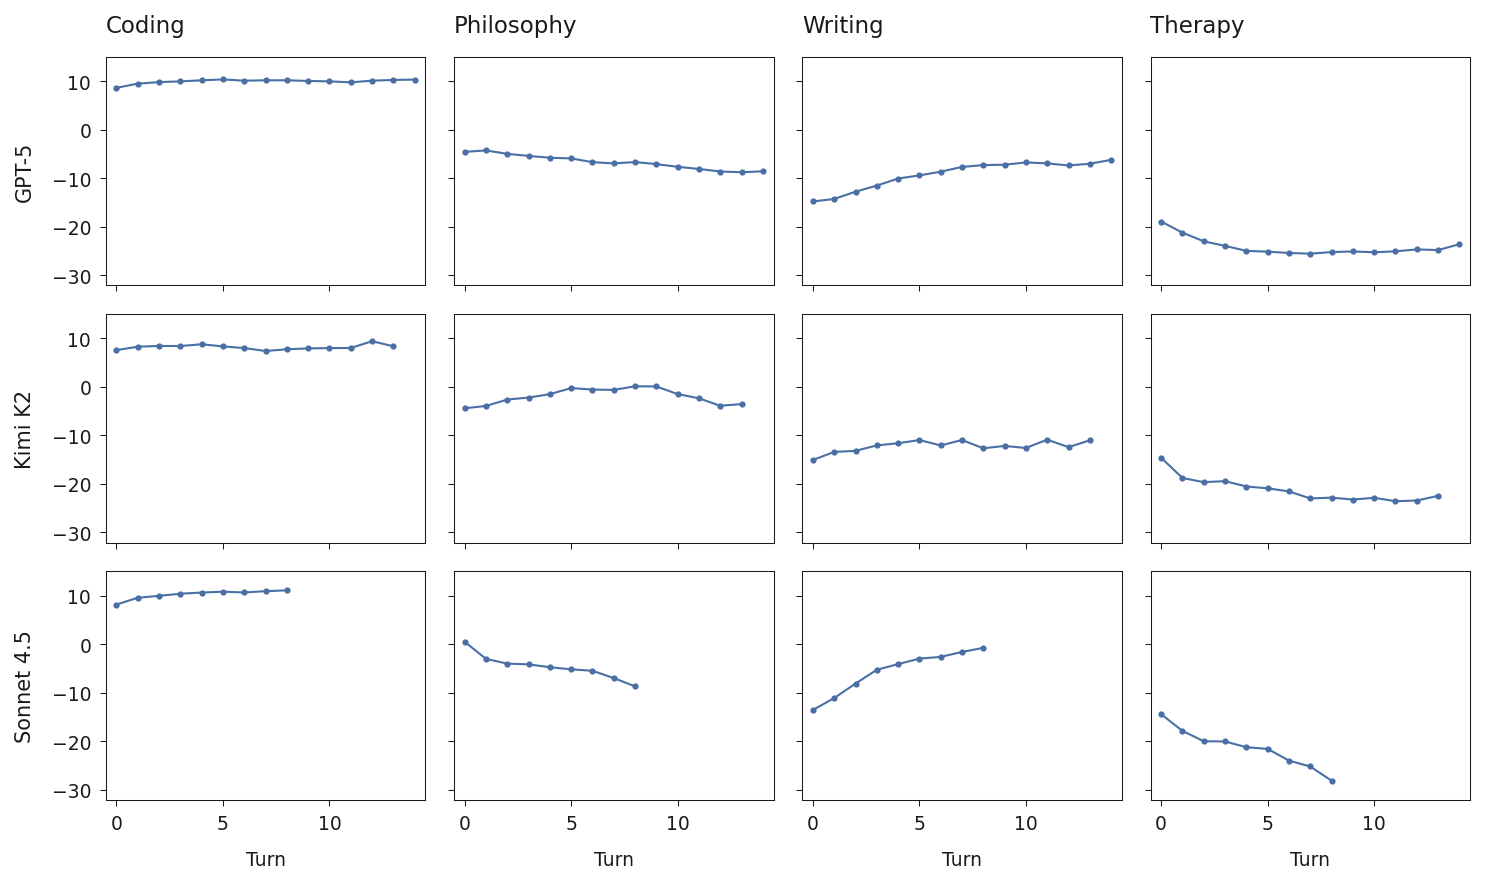

qwen-3-32b


In [ ]:
# Plot grid: rows = auditors, columns = domains (PC1 projection)
n_auditors = len(auditor_models)
fig, axes = plt.subplots(n_auditors, 4, figsize=(10, 2 * n_auditors), sharex=True, sharey=True)

# Handle single auditor case (axes won't be 2D)
if n_auditors == 1:
    axes = axes.reshape(1, -1)

# Compute global y-range across all auditors and domains
all_y = np.concatenate([
    auditor_domain_pc1_projs[auditor][domain]
    for auditor in auditor_models
    for domain in domain_order
])
y_min, y_max = np.nanmin(all_y), np.nanmax(all_y)
y_pad = (y_max - y_min) * 0.1
y_range = (y_min - y_pad, y_max + y_pad)

# Compute global x-range
max_turns = max(
    len(auditor_domain_pc1_projs[auditor][domain])
    for auditor in auditor_models
    for domain in domain_order
)

for row_idx, auditor in enumerate(auditor_models):
    for col_idx, domain in enumerate(domain_order):
        ax = axes[row_idx, col_idx]
        proj = auditor_domain_pc1_projs[auditor][domain]
        turn_indices = np.arange(len(proj))
        
        ax.plot(turn_indices, proj,
                color=PC_COLORS[0],
                marker='o',
                markersize=3,
                linewidth=1)
        
        ax.set_ylim(y_range)
        ax.set_xlim(-0.5, max_turns - 0.5)
        
        # Ensure box around subplot (all spines visible)
        for spine in ax.spines.values():
            spine.set_visible(True)
        
        # Column titles (domain names) on top row
        if row_idx == 0:
            ax.set_title(domain_display.get(domain, domain.capitalize()), fontsize=11)
        
        # Row labels (auditor names) on left column
        if col_idx == 0:
            ax.set_ylabel(auditor_display.get(auditor, auditor), fontsize=10)
        
        # X-axis label on bottom row
        if row_idx == n_auditors - 1:
            ax.set_xlabel('Turn', fontsize=9)

plt.tight_layout()
plt.show()
print(target_model)